<!-- # Setup

## Colab -->

In [1]:
# # Mount the drive and move to dir
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
# Switch to current dir
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

/content/drive/MyDrive/Coding/spread-res/runscr


<!-- ## Imports -->

In [2]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import os
import sys

import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# from classes.models import BertPooler

# Import the utilities and the dataloader
from utils import inferutil, setuputil, trainutil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)
# importlib.reload(BertPooler)

# Import the model
# from classes.models.BertPooler import BertPooler
from utils.inferutil import infer_full, infer_one

# Import the funcs needed from utils
from utils.setuputil import display_config, setup_config
from utils.trainutil import train_model

<!-- ## Configuration -->

In [3]:
input_config = {
    # Environment and Model Info
    "env": "colab",
    "approach": "bert",
    "model_name": "BertPoolerPos",
    "model_base": "bert-base-cased",
    # System Configuration
    "device": "cuda:0",
    "threads": 10,
    "seed": 0,
    # Data Configuration
    "data_dir": "../data",
    "data_ds": "manual",
    # Model Parameters
    "rows": 100,
    "cols": 100,
    "tokens": 32,
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 32,
    "num_hidden_layers": 1,
    "num_attention_heads": 1,
    "intermediate_size": 128,
    # Training Parameters
    "batch_size": 40,
    "lr": 1e-2,
    "mu": 0.25,
    "epochs": 20,
    "patience": 2,
    "save_int": 0,
    "save_dir": "../models/",
}
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 40/40 [00:09<00:00,  4.37it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 3228.87it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 3545.48it/s]



5(P) = 5(G) + 0(E)
{
  "env": "colab",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 10,
  "seed": 0,
  "model_base": "bert-base-cased",
  "model_name": "BertPoolerPos",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 32,
  "num_hidden_layers": 1,
  "num_attention_heads": 1,
  "intermediate_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 40,
  "lr": 0.01,
  "mu": 0.25,
  "epochs": 20,
  "patience": 2,
  "sa

<!-- # Model Creation -->

<!-- ## NEW MODEL DEFINITION HERE -->

In [4]:
# Imports
import math

import torch
import torch.nn as nn
from transformers import BertConfig, BertModel
from transformers.models.bert.modeling_bert import BertEncoder


# Define the BertPos class
class BertPos(nn.Module):
    """A BERT-based model that combines positional and content understanding for grid-structured data.

    This model processes grid-structured input through BERT embeddings enriched with positional
    encodings for both row and column positions. It uses a combination of BERT encoding and
    positional information to create a rich representation of grid cells.

    Args:
    config (dict): Configuration dictionary containing model parameters.
    """

    def __init__(self, config):
        super().__init__()

        # Extract common params
        self.device = config["DEVICE"]
        self.rows = config["rows"]
        self.cols = config["cols"]
        self.seq_len = config["tokens"]
        self.hidden_size = config["hidden_size"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]

        # Create config to be used for both base model and encoder
        self.bert_config = BertConfig(
            vocab_size=config["vocab_size"],
            hidden_size=self.hidden_size,
            intermediate_size=config["intermediate_size"],
            num_hidden_layers=config["num_hidden_layers"],
            num_attention_heads=config["num_attention_heads"],
            hidden_act=config["hidden_act"],
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=config["attention_probs_dropout_prob"],
            max_position_embeddings=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            layer_norm_eps=config["layer_norm_eps"],
            initializer_range=config["initializer_range"],
            pad_token_id=config["pad_token_id"],
            gradient_checkpointing=config["gradient_checkpointing"],
            seed=config["seed"],
        )

        # Initialize both the BERT model and the enriched encoder using the same config.
        self.bertModel_cell = BertModel(self.bert_config)
        self.bertEncoder_spatial = BertEncoder(self.bert_config)

        # Precompute pos encs for grid cells [max(rows, cols), hidden_size]
        self.pos_encodings = self.get_posEncoding()

        # Final binary classification layers wrapped sequentially
        self.binary_classifier = nn.Sequential(
            nn.Dropout(self.hidden_dropout_prob),
            nn.GELU(),
            nn.Linear(self.hidden_size, 1),
        )

    # Function to get positional encodings for cells
    def get_posEncoding(self):
        """Generates positional encodings for grid cells using sinusoidal functions.

        Creates a matrix of positional encodings where each row corresponds to a position in the grid (either row or column position). Uses sine and cosine functions of different frequencies to create unique position embeddings.

        Returns:
            torch.Tensor: A tensor of shape [max_dim, hidden_size] containing positional
                encodings, where max_dim is the maximum between number of rows and columns.
                The encodings can be used for both row and column position encoding.
        """

        # Max of rows/cols is the number of positions we have
        max_dim = max(self.rows, self.cols)

        # Initialize the positional encoding matrix [max_dim, hidden_size]
        posEncoding = torch.zeros(max_dim, self.hidden_size, device=self.device)

        # Create [max_dim, 1] position vector
        pos = torch.arange(max_dim, dtype=torch.float, device=self.device).unsqueeze(1)

        # Compute a [hidden_size/2] vector for the exponential scaling
        # This replaces repeated pow(10000, 2i/hidden_size) calls
        div_term = torch.exp(
            torch.arange(0, self.hidden_size, 2, dtype=torch.float, device=self.device)
            * (-math.log(10000.0) / self.hidden_size)
        )

        # Apply sin to even indices and cos to odd indices
        posEncoding[:, 0::2] = torch.sin(pos * div_term)
        posEncoding[:, 1::2] = torch.cos(pos * div_term)

        # Return final matrix of all positional encodings
        return posEncoding

    # Normal optimized forward function
    def forward(self, input_ids, attention_mask):
        """Processes input through the model to generate grid cell representations.

        Takes tokenized input for each cell in the grid, processes it through BERT,
        combines it with positional information, and generates final cell representations
        through an encoder and classification head.

        Args:
            input_ids (torch.Tensor): Tensor of shape [batch_size, rows, cols, seq_len]
            containing token IDs for each cell in the grid.
            attention_mask (torch.Tensor): Tensor of shape [batch_size, rows, cols,     seq_len] containing attention masks for each cell.

        Returns:
            torch.Tensor: A tensor of shape [batch_size, rows, cols] containing the final
        representations for each cell in the grid (S_cube).
        """

        # Retrieve dims and initialize init tensor for posContext embeddings
        batch_size, rows, cols, seq_len = input_ids.shape
        posContext_embeddings = torch.zeros(
            (batch_size, rows * cols, self.hidden_size),
            device=input_ids.device,
        )

        # Build enriched encodings combining content and position understanding
        for cell in range(rows * cols):

            # Define row and column indices for current cell
            row = cell // self.cols
            col = cell % self.cols

            # Calculate the enriched encoding for the cell
            posContext_embeddings[:, cell, :] = (
                self.bertModel_cell(
                    input_ids=input_ids[:, row, col, :],
                    attention_mask=attention_mask[:, row, col, :],
                ).pooler_output
                + self.pos_encodings[row]
                + self.pos_encodings[col]
            )

        # Process through encoder and classification head, reshape to grid format
        S_cube = (
            self.binary_classifier(self.bertEncoder_spatial(posContext_embeddings)[0])
            .squeeze(-1)
            .reshape(batch_size, rows, cols)
        )

        # Return the S_cube
        return S_cube

<!-- ### Single Batch Checking -->

In [5]:
torch.set_printoptions(precision=4, sci_mode=False)

# # Define parameters where loc is the index of file and test_batch_size is the batch size for testing
# test_batch_size = 1

# # Create check loader from the train_loader Dataset
# check_loader = torch.utils.data.DataLoader(
#     train_loader, batch_size=test_batch_size, shuffle=False
# )

# # Get first batch using next() and iter()
# check_batch = next(iter(check_loader))

# # Extract all the relevant tensors/info at loc
# ex_file = check_batch["file_paths"]
# ex_xtok = check_batch["x_tok"].to(DEVICE)
# ex_xmasks = check_batch["x_masks"].to(DEVICE)
# ex_ytok = check_batch["y_tok"]

# # Print the extracted info
# print(f"Filename: {ex_file}")
# print(f"x_tok shape: {ex_xtok.shape}")
# print(f"x_masks shape: {ex_xmasks.shape}")
# print(f"y_tok shape: {ex_ytok.shape}\n")

# Define the model and move it to the device
untrained_model = BertPos(config).to(DEVICE)
print(untrained_model)

"""
NOTE: Model takes up 521 Mb with hidden 32 and intermediate 128
"""

BertPos(
  (bertModel_cell): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 32, padding_idx=0)
      (position_embeddings): Embedding(64, 32)
      (token_type_embeddings): Embedding(2, 32)
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=32, out_features=32, bias=True)
              (key): Linear(in_features=32, out_features=32, bias=True)
              (value): Linear(in_features=32, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=32, out_features=32, bias=True)
              (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
    

'\nNOTE: Model takes up 521 Mb with hidden 32 and intermediate 128\n'

In [6]:
# # Now do a single forward pass and see outputs
# out = untrained_model.forward2(ex_xtok, ex_xmasks)
# print(f"\nOutput ({out.shape}):\n{out}")

# # Check sigmoid vals also
# print(f"\nSigmoid Output:\n{torch.sigmoid(out)}")

In [7]:
# # 1) Create model and move to GPU Observe its architecture - 440 Mib
# untrained_model = BertPooler(config).to(DEVICE)
# print(untrained_model)

<!-- # Model Training -->

In [8]:
# Train with adjusted batch size
trained_model = train_model(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
)

"""
NOTE:

Batch Size 14 maxes out GPU usage at 39/40 GB and takes 01:49 mins per epoch

Batch size 10 had more buffer with 28/40 GB used, but took 02:30 mins per epoch
"""

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.61s/it]


Train Loss: 1.5001763105392456, Perplexity: 1.0000037504478092
Val Loss: 1.1921906471252441, Perplexity: 1.0000029804810595


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.90s/it]


Train Loss: 1.2125389575958252, Perplexity: 1.0000030313519885
Val Loss: 1.2104673385620117, Perplexity: 1.0000030261729254


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.12s/it]


Train Loss: 1.249038577079773, Perplexity: 1.000003122601318
Val Loss: 1.0274865627288818, Perplexity: 1.000002568719706


Epoch 3


Validation Processing: 100%|██████████| 1/1 [00:14<00:00, 14.98s/it]


Train Loss: 1.0533913373947144, Perplexity: 1.000002633481811
Val Loss: 0.8800616264343262, Perplexity: 1.0000022001564863


Epoch 4


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.01s/it]


Train Loss: 0.9258982539176941, Perplexity: 1.000002314748314
Val Loss: 0.7892019152641296, Perplexity: 1.0000019730067344


Epoch 5


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.31s/it]


Train Loss: 0.820340633392334, Perplexity: 1.0000020508536864
Val Loss: 0.5747075080871582, Perplexity: 1.0000014367698025


Epoch 6


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.12s/it]


Train Loss: 0.6321220993995667, Perplexity: 1.0000015803064972
Val Loss: 0.45656269788742065, Perplexity: 1.0000011414073962


Epoch 7


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.16s/it]


Train Loss: 0.501716136932373, Perplexity: 1.000001254291129
Val Loss: 0.31587231159210205, Perplexity: 1.0000007896810907


Epoch 8


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.15s/it]


Train Loss: 0.36777937412261963, Perplexity: 1.000000919448858
Val Loss: 0.2601486146450043, Perplexity: 1.000000650371748


Epoch 9


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.14s/it]


Train Loss: 0.3012649118900299, Perplexity: 1.0000007531625634
Val Loss: 0.2060873806476593, Perplexity: 1.0000005152185842


Epoch 10


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.13s/it]


Train Loss: 0.2506842017173767, Perplexity: 1.0000006267107007
Val Loss: 0.18331852555274963, Perplexity: 1.0000004582964188


Epoch 11


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.10s/it]


Train Loss: 0.22020746767520905, Perplexity: 1.0000005505188208
Val Loss: 0.15869219601154327, Perplexity: 1.0000003967305686


Epoch 12


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.23s/it]


Train Loss: 0.1970372349023819, Perplexity: 1.0000004925932087
Val Loss: 0.14527948200702667, Perplexity: 1.000000363198771


Epoch 13


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.09s/it]


Train Loss: 0.1795661300420761, Perplexity: 1.000000448915426
Val Loss: 0.173936128616333, Perplexity: 1.0000004348404161


Epoch 14


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.12s/it]


Train Loss: 0.16059474647045135, Perplexity: 1.0000004014869468
Val Loss: 0.12462274730205536, Perplexity: 1.0000003115569167


Epoch 15


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.20s/it]


Train Loss: 0.14448846876621246, Perplexity: 1.0000003612212371
Val Loss: 0.13444633781909943, Perplexity: 1.0000003361159011


Epoch 16


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.10s/it]


Train Loss: 0.13296684622764587, Perplexity: 1.000000332417171
Val Loss: 0.1390780210494995, Perplexity: 1.0000003476951131


EARLY STOPPING at epoch 16, best epoch 14
Train Loss = 0.16059474647045135, Perplexity = 1.0000004014869468
Val Loss = 0.12462274730205536, Perplexity = 1.0000003115569167


TRAINING DONE at epoch 16, best epoch 14
Train Loss = 0.16059474647045135, Perplexity = 1.0000004014869468
Val Loss = 0.12462274730205536, Perplexity = 1.0000003115569167


'\nNOTE:\n\nBatch Size 14 maxes out GPU usage at 39/40 GB and takes 01:49 mins per epoch\n\nBatch size 10 had more buffer with 28/40 GB used, but took 02:30 mins per epoch\n'

<!-- # Evaluation -->

<!-- ## Single Example -->


Filename: ../data/manual_train/dlportfoliobydelinquencystatus.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(39,13): 0.80132818222045898438
(39,12): 0.83436775207519531250
(39,9): 0.84815001487731933594
(37,0): 0.84888821840286254883
(37,1): 0.84968930482864379883
(39,8): 0.85025823116302490234
(39,10): 0.85134840011596679688
(39,11): 0.85146510601043701172
(39,0): 0.85311722755432128906
(39,7): 0.85477656126022338867
(39,1): 0.85585308074951171875
(32,0): 0.85609900951385498047
(36,0): 0.85702091455459594727
(39,2): 0.85857945680618286133
(36,1): 0.85893398523330688477
(33,0): 0.85956442356109619141
(39,6): 0.86022961139678955078
(31,0): 0.86092174053192138672
(34,1): 0.86136001348495483398
(33,1): 0.86159741878509521484
(35,1): 0.86178374290466308594
(39,3): 0.86221104860305786133
(35,0): 0.86224389076232910156
(34,0): 0.86262357234954833984
(39,5): 0.86566400527954101562
(32,1): 0.86571609973907470703
(39,4): 0.86602544784545898438
(30,0): 0.87202656269073486328
(31,1): 

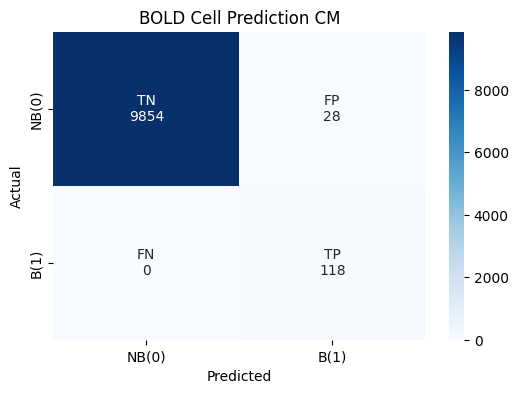


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,0,0,0,0
3,0,0,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# Params
loc = 0
thresh = 0.5

# Inference on single position of train_loader
infer_one(
    trained_model=trained_model,
    infer_loader=train_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)


Filename: ../data/100_val/LMDI_Combined.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
No bold cells in the actual data.

NB to B ratio: Predicted = 9950:50 | Actual = 10000:0
Accuracy: 99.50% | Precision: 0.00% | Recall: 0.00% | F1-Score: 0.00



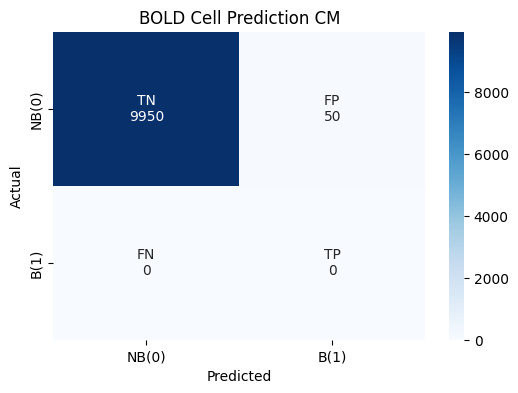


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3
0,1,1,0,1
1,1,0,1,1
2,1,1,1,1
3,1,0,1,1
4,1,1,1,0
5,1,1,1,1
6,1,1,1,1
9,1,1,0,1
10,1,1,1,1
11,1,0,0,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---
No bold cells in actual data.


In [ ]:
# Inference on single position of val_loader
infer_one(
    trained_model=trained_model,
    infer_loader=val_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)


Filename: ../data/100_test/1415-bassessment-1.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(8,4): 0.92966681718826293945
(8,6): 0.93005162477493286133
(8,5): 0.93070644140243530273
(8,3): 0.93263036012649536133
(8,2): 0.93335318565368652344
(8,0): 0.93370175361633300781
(6,0): 0.93388009071350097656
(8,1): 0.93396514654159545898

NB to B ratio: Predicted = 9895:105 | Actual = 9992:8
Accuracy: 99.01% | Precision: 6.67% | Recall: 87.50% | F1-Score: 0.12



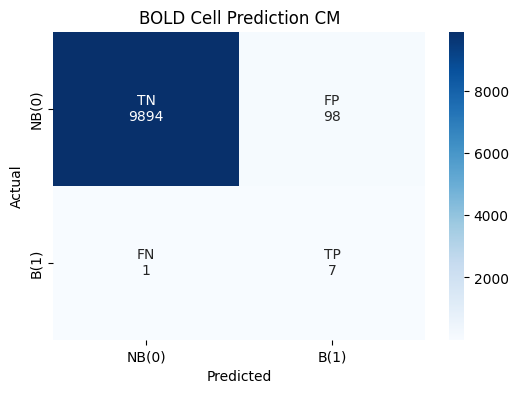


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
0,1,1,0,0,0,0,0
1,1,1,0,0,0,0,0
2,1,1,0,0,0,0,0
3,1,1,0,0,0,0,0
4,1,1,0,0,0,0,0
6,1,0,0,0,0,0,0
8,1,1,1,1,0,1,1
9,0,1,1,1,1,1,0
10,0,0,1,0,1,1,0
11,1,1,1,0,1,1,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
6,1,0,0,0,0,0,0
8,1,1,1,1,1,1,1


In [ ]:
# Inference on single position of test_loader
infer_one(
    trained_model=trained_model,
    infer_loader=test_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

<!-- ## All Examples -->

Batch Inference: 100%|██████████| 8/8 [01:52<00:00, 14.09s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 793131:6869 | Actual = 798240:1760
Accuracy: 99.24% | Precision: 17.29% | Recall: 75.17% | F1-Score: 0.27



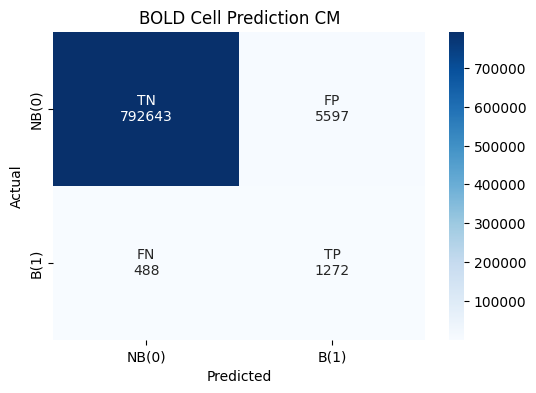

In [ ]:
# Determine batch size to use for inference
infer_batch_size = 10

# Infer across all examples of train_loader
infer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 1/1 [00:14<00:00, 14.10s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 99420:580 | Actual = 99799:201
Accuracy: 99.45% | Precision: 20.00% | Recall: 57.71% | F1-Score: 0.30



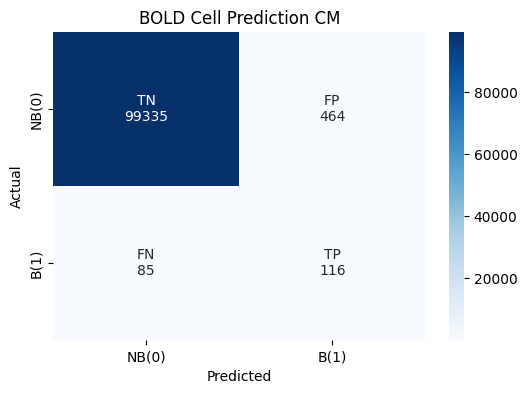

In [ ]:
# Infer across all examples of val_loader
infer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=infer_batch_size,
    threshold=0.9331,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 1/1 [00:14<00:00, 14.17s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 98711:1289 | Actual = 99738:262
Accuracy: 98.89% | Precision: 17.07% | Recall: 83.97% | F1-Score: 0.28



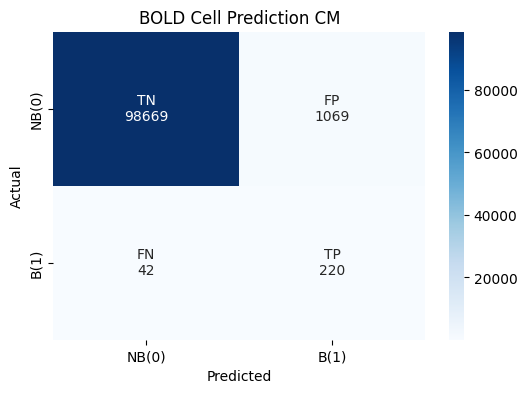

In [ ]:
# Infer across all examples of test_loader
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)